# Skew-T of IGP sounding!

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd

import metpy.calc as mpcalc
from metpy.plots import SkewT, Hodograph
from metpy.units import units

# %matplotlib inline

In [2]:
# Change default to be better for skew-T
plt.rcParams['figure.figsize'] = (9, 9)

In [3]:
fname = '../data/radiosonde/edt_1s_20180212_1139.txt'

In [4]:
# df = pd.read_fwf(fname, as_file_obj=False,
#                  skiprows=13, 
#                  usecols=['P', 'Temp', 'Dewp', 'Speed', 'Dir', 'Ecomp', 'Ncomp', 'GpsHeightMSL'])

To load the data I decided to use the good old `read_csv()` function, as you can see below.

In [5]:
df = pd.read_csv(fname,
                 skiprows=[*range(13)] + [14],
                 delimiter='\t')

You see that `skiprows=` can actually take a list of row numbers, not just the total number.

and with a bit of Python list operations we can do it like this:

In [6]:
[*range(13)] + [14]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]

or like this:

In [7]:
l = [*range(15)]
l.remove(13)
l

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]

The only small problem remaining is that column names have trailing whitespaces in them:

In [8]:
df.columns

Index(['Elapsed time', ' TimeUTC', '    P', ' Temp', 'RH', ' Dewp', 'Speed',
       'Dir', 'Ecomp', 'Ncomp', '      Lat', '       Lon', 'AscRate',
       'HeightMSL', 'GpsHeightMSL', 'PotTemp', 'SpHum', 'CompRng', 'CompAz'],
      dtype='object')

But this can be easily fixed:

In [9]:
df.columns = [i.strip() for i in  df.columns]

Print what we have so far

In [10]:
df.head()

,Elapsed time,TimeUTC,P,Temp,RH,Dewp,Speed,Dir,Ecomp,Ncomp,Lat,Lon,AscRate,HeightMSL,GpsHeightMSL,PotTemp,SpHum,CompRng,CompAz
0,0,11:39:16,979.8,0.0,64,-6.0,12.5,177,-0.7,12.5,67.890327,-13.979096,0.0,0,0,1.6,2.486,0,0
1,1,11:39:17,979.4,0.3,65,-5.4,8.6,179,-0.1,8.6,67.898883,-13.945238,2.0,3,3,2.0,2.602,843,33
2,2,11:39:18,978.9,0.9,66,-4.8,5.9,183,0.3,5.9,67.905051,-13.920849,4.0,7,7,2.6,2.714,1452,55
3,3,11:39:19,978.1,1.8,64,-4.3,5.5,182,0.2,5.5,67.906225,-13.916295,4.9,12,13,3.6,2.826,1568,55
4,4,11:39:20,977.7,2.0,63,-4.2,5.6,179,-0.1,5.6,67.906285,-13.916270,4.5,17,17,3.8,2.835,1572,55


Then for convenience we can select only those columns that we want

In [11]:
df = df[['P', 'Temp', 'Dewp', 'Speed', 'Dir', 'Ecomp', 'Ncomp', 'GpsHeightMSL']]

In [12]:
df.head()

,P,Temp,Dewp,Speed,Dir,Ecomp,Ncomp,GpsHeightMSL
0,979.8,0.0,-6.0,12.5,177,-0.7,12.5,0
1,979.4,0.3,-5.4,8.6,179,-0.1,8.6,3
2,978.9,0.9,-4.8,5.9,183,0.3,5.9,7
3,978.1,1.8,-4.3,5.5,182,0.2,5.5,13
4,977.7,2.0,-4.2,5.6,179,-0.1,5.6,17


We can also test if there are any NaNs

In [13]:
df.isnull().sum()

P               0
Temp            0
Dewp            0
Speed           0
Dir             0
Ecomp           0
Ncomp           0
GpsHeightMSL    0
dtype: int64

It seems that there is no bad values in the dataframe, so we can omit the `dropna()` step.

Now we can extract the numpy arrays and attach units to them

In [14]:
ptop = 300

In [15]:
df = df[df['P']>ptop]

In [16]:
# We will pull the data out of the example dataset into individual variables and assign units.
p = df['P'].values * units.hPa
T = df['Temp'].values * units.degC
Td = df['Dewp'].values * units.degC
wind_speed = df['Speed'].values * units.knots
wind_dir = df['Dir'].values * units.degrees
# u, v = df('Ecomp', 'Ncomp')
u = (df['Ecomp'].values * units.Unit('m/s'))# .to('knots')
v = (df['Ncomp'].values * units.Unit('m/s'))# .to('knots')

And finally, put everything on the plot

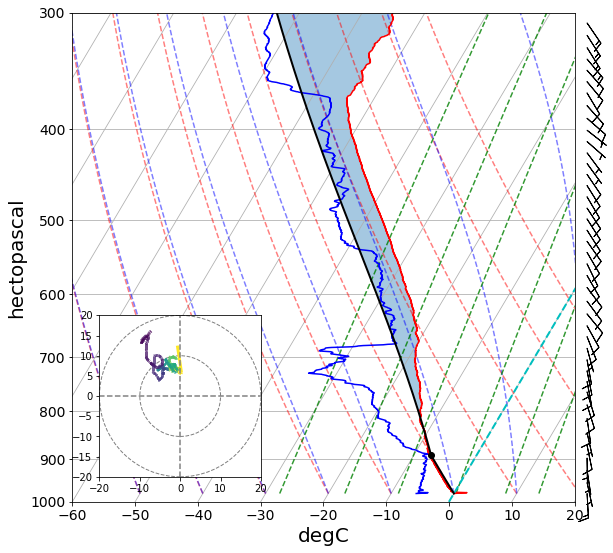

In [18]:
# Alternatively create a figure first:
fig = plt.figure()
skew = SkewT(fig=fig)

skew.plot(p, T, 'r')
skew.plot(p, Td, 'b')

skew.plot_dry_adiabats(t0=np.arange(-50, 50, 10) * units.degC, p=p[p>ptop*units.hPa])
skew.plot_moist_adiabats(t0=np.arange(-50, 50, 10) * units.degC, p=p[p>ptop*units.hPa])
skew.plot_mixing_lines(p=p[p>ptop*units.hPa])
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)
skew.ax.set_ylim(1000, ptop)
skew.ax.set_xlim(-60, 20)

skew.plot_barbs(p[::50], u[::50], v[::50], xloc=1.025);


# Calculate LCL height and plot as black dot
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, prof)
skew.shade_cape(p, T, prof)

skew.ax.tick_params(labelsize=14)
skew.ax.xaxis.label.set_size(20)
skew.ax.yaxis.label.set_size(20)


# Create a hodograph
ax_hod = inset_axes(skew.ax, '33%', '33%', loc=3, borderpad=2.5)
h = Hodograph(ax_hod, component_range=20.)
h.add_grid(increment=10)
h.plot_colormapped(u, v, p)

# fig.savefig('igp-skewt-example.png', bbox_inches='tight', dpi=300)